In [ ]:
# This tests algorithms to remove cosmic rays from multiepoch spectra (in particular from SDSS stripe 82
# spectra, which are too many for manual removal)

# Created 2021 May 10 by E.S.

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

%matplotlib inline

In [2]:
stem = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/"
file_list = glob.glob(stem + "*")

In [3]:
# find all parent names (i.e., one name for each target, whether or not multiepoch observations were made)

parent_list = list(set([i.split("g00")[0] for i in file_list]))

In [4]:
file_1 = "spec-2618-54506-0488g001.dat_000"
file_2 = "spec-2618-54506-0488g002.dat_000"

df1 = pd.read_csv(stem + file_1, names=["wavel","flux","cont"], delim_whitespace = True)
df2 = pd.read_csv(stem + file_2, names=["wavel","flux","cont"], delim_whitespace = True)

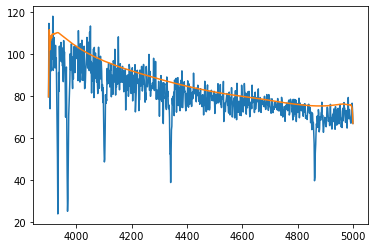

In [5]:
plt.plot(df1["wavel"], df1["flux"])
plt.plot(df1["wavel"], df1["cont"])
plt.show()

In [ ]:
# initialize list to hold single-epoch spectra names
## TBD

In [6]:
def plot_result(spec0, spec1):
    
    # remove from consideration the regions around the absorption lines, which change with time and can 
    # be misidentified as a cosmic ray hit (a spectrum with an actual hit will have to be discarded manually)
    spec0_flux_copy = spec0["flux"].to_numpy()
    spec1_flux_copy = spec1["flux"].to_numpy()
    half_width = 20
    cond_1 = np.logical_and(spec0["wavel"] > 3933.66-half_width, spec0["wavel"] < 3933.66+half_width)
    cond_2 = np.logical_and(spec0["wavel"] > 3970.075-half_width, spec0["wavel"] < 3970.075+half_width)
    cond_3 = np.logical_and(spec0["wavel"] > 4101.71-half_width, spec0["wavel"] < 4101.71+half_width)
    cond_4 = np.logical_and(spec0["wavel"] > 4340.472-half_width, spec0["wavel"] < 4340.472+half_width)
    cond_5 = np.logical_and(spec0["wavel"] > 4861.29-half_width, spec0["wavel"] < 4861.29+half_width)
    spec0_flux_copy[cond_1] = np.nan
    spec0_flux_copy[cond_2] = np.nan
    spec0_flux_copy[cond_3] = np.nan
    spec0_flux_copy[cond_4] = np.nan
    spec0_flux_copy[cond_5] = np.nan
    spec1_flux_copy[cond_1] = np.nan
    spec1_flux_copy[cond_2] = np.nan
    spec1_flux_copy[cond_3] = np.nan
    spec1_flux_copy[cond_4] = np.nan
    spec1_flux_copy[cond_5] = np.nan
    
    resids = np.subtract(spec0_flux_copy,spec1_flux_copy)
    
    # sigma clip
    # (note sigma lower is a large number, to keep track of which spectrum has the (+) cosmic ray)
    filtered_data = sigma_clip(resids, sigma_lower=50, sigma_upper=5, iters=1)
    
    # also remove points adjacent to those masked, by rolling spectra by two elements in each direction,
    # subtracting them and finding where difference is nan
    diff_roll_p1 = np.subtract(filtered_data,np.roll(filtered_data,1))
    diff_roll_p2 = np.subtract(filtered_data,np.roll(filtered_data,2))
    diff_roll_n1 = np.subtract(filtered_data,np.roll(filtered_data,-1))
    diff_roll_n2 = np.subtract(filtered_data,np.roll(filtered_data,-2))
    mark_bad_array = np.subtract(np.subtract(diff_roll_p1,diff_roll_p2),np.subtract(diff_roll_n1,diff_roll_n2))
    mask_bad_pre_line_restore = np.ma.getmask(mark_bad_array)
    
    masked_flux_0 = np.ma.masked_array(spec0["flux"], mask=mask_bad)
    masked_wavel_0 = np.ma.masked_array(spec0["wavel"], mask=mask_bad)
    masked_flux_1 = np.ma.masked_array(spec1["flux"], mask=mask_bad)
    masked_wavel_1 = np.ma.masked_array(spec1["wavel"], mask=mask_bad)

    num_removed = np.subtract(len(resids), np.isfinite(filtered_data).sum())
    
    plt.clf()
    fig = plt.figure(figsize=(24,9))
    plt.plot(df_single_0["wavel"],resids,color="red")
    #plt.plot(df_single_0["wavel"],df_single_0["flux"])
    plt.plot(df_single_0["wavel"],spec0_flux_copy)
    #plt.plot(df_single_1["wavel"],df_single_1["flux"])
    plt.plot(masked_wavel_0,masked_flux_0,color="k")
    #plt.title("pts removed: " + str(num_removed))
    #plt.show()
    string_rand = str(np.random.randint(low=0,high=10000))
    plt.savefig("junk_"+string_rand+".png")
    
    return

<Figure size 432x288 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

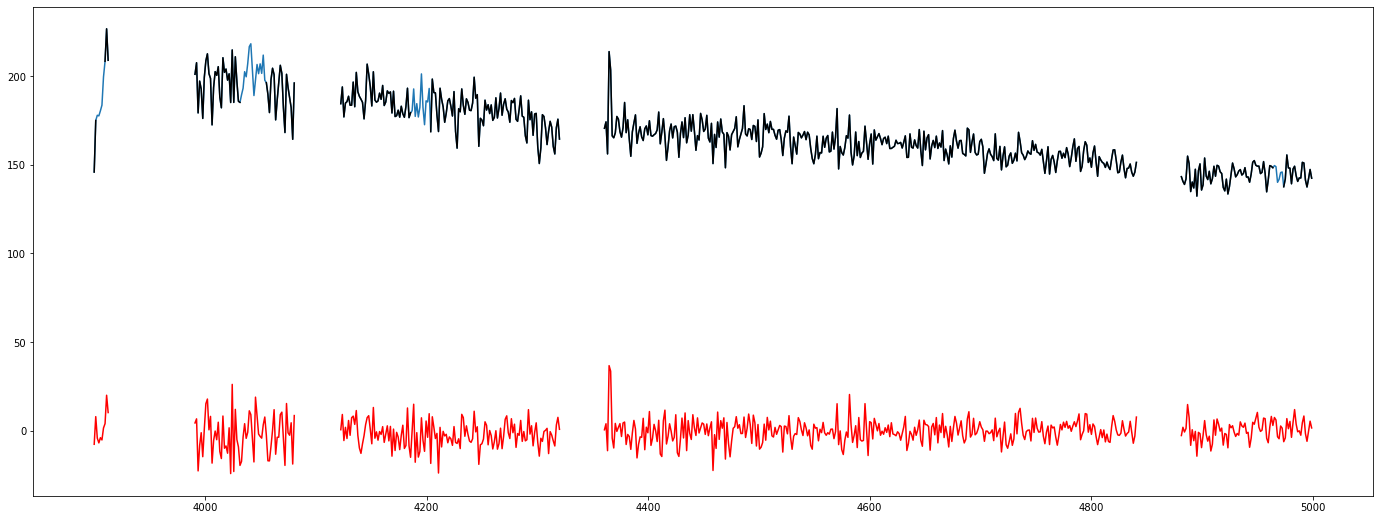

In [53]:
# find the file names of spectra corresponding to each parent; if there is only 1, ignore; 
# if >= 2, do median comparison to flag it for cosmic rays

for t in range(0,60):#len(parent_list)):
    
    #print("----------")
    #print(t)
    matching = list(filter(lambda x: parent_list[t] in x, file_list))
    
    if (len(matching) == 1):
        
        continue
    
    elif (len(matching) == 2):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        
        plot_result(df_single_0, df_single_1)
        
        
    elif (len(matching) == 3):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_2 = pd.read_csv(matching[2], names=["wavel","flux","noise"], delim_whitespace=True)
        
    elif (len(matching) > 3):
        
        continue

In [ ]:
## NEW METHOD

In [11]:
# find names of spectra for which continuum has been calculated

stem_s82_norm = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/"
# find individual file names
file_list = glob.glob(stem_s82_norm + "*")
# find all parent names (i.e., one name for each target, whether or not multiepoch observations were made)
parent_list = list(set([i.split("g00")[0] for i in file_list]))

In [57]:
def mean_spec(df_1_pass,df_2_pass):
    '''
    Average two spectra and flag points based on their deviation from the average spectrum
    
    INPUTS:
    df_1_pass: dataframe including wavelength and flux
    df_2_pass: "  "
    '''
    
    # sanity check that we are not averaging flux at different wavelengths
    if ((len(df_1_pass) == len(df_2_pass)) and 
        (df_1_pass["wavel"].iloc[0] == df_2_pass["wavel"].iloc[0]) and 
        (df_1_pass["wavel"].iloc[-1] == df_2_pass["wavel"].iloc[-1])):
    
        print("Looks like sane comparison")
    
    else:
        
        print("Apples and oranges!")
        return
    
    df_concat = pd.concat((df1["flux"], df2["flux"]),axis=1)
    df_concat["avg_cols"] = df_concat.mean(axis=1).values 
    
    avg_spec = df_1_pass.copy(deep=True)
    avg_spec["flux"] = df_concat["avg_cols"]
    avg_spec = avg_spec.drop(columns="noise")
    
    return avg_spec

In [61]:
def flag_from_avg(df_empir_pass,df_avg_pass,sigma_choice=1):
    '''
    Average two spectra and flag points based on their deviation from the average spectrum
    
    INPUTS:
    df_empir_pass: dataframe of empirical spectrum
    df_avg_pass: dataframe of average spectrum
    sigma_choice: threshold for clipping
    '''
    
    # initialize
    masked_spec = df_empir_pass.copy(deep=True)
    masked_spec["flux_masked1"] = masked_spec["flux"]
    
    # take difference (note this preserves sign information)
    masked_spec["diff"] = np.subtract(df_empir_pass["flux"],df_avg_pass["flux"])
    
    # mask deviant points
    masked_spec["flux_masked1"] = masked_spec["flux_masked1"].mask(
                                                                    masked_spec["diff"] > sigma_choice*np.nanstd(masked_spec["diff"]), 
                                                                    inplace=True
                                                                    )
    
    return masked_spec

In [58]:
avg_spec_A = mean_spec(df_single_0,df_single_1)

Looks like sane comparison


In [62]:
test = flag_from_avg(df_single_0,avg_spec_A,sigma_choice=1)

In [63]:
test

,wavel,flux,noise,flux_masked1,diff
0,3900.0,61.85,61.85000,None,-18.295
1,3901.4,68.65,66.79679,None,-33.385
2,3902.8,68.55,70.61259,None,-21.905
3,3904.2,73.07,72.40039,None,-23.040
4,3905.6,78.36,74.58567,None,-5.240
...,...,...,...,...,...
781,4993.4,59.69,60.78291,None,-6.795
782,4994.8,59.00,60.95886,None,-9.605
783,4996.2,58.66,60.55286,None,-13.120
784,4997.6,60.51,61.40366,None,-10.530


In [52]:
# Steps for removing cosmic rays from spectra with >1 for a given object

# Step 1:
# Average two normalized spectra (following the normalization of the raw spectra)
# Flag (#1) points that are N sigma off from the average [use cenfunc=“median”]; keep track of direction

# Step 2:
# Go back to the spectra BEFORE ANY NORMALIZATION and averaging, and remove (mask) the flagged points
# Normalize them anew
# Sigma-clip again, but use larger sigmas than in Step 1, and flag those points with another flag (#2)
# Remove (mask) those points from the spectra

# Step 3:
# Normalize one last time


# find the file names of spectra corresponding to each parent; if there is only 1, ignore; 
# if >= 2, do median comparison to flag it for cosmic rays

for t in range(0,1):#len(parent_list)):
    
    matching = list(filter(lambda x: parent_list[t] in x, file_list))
    
    if (len(matching) == 1):
        
        continue
    
    elif (len(matching) == 2):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        
        # average 
        avg_spec_A = mean_spec(df_single_0,df_single_1)
        
    elif (len(matching) == 3):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_2 = pd.read_csv(matching[2], names=["wavel","flux","noise"], delim_whitespace=True)
        
        # average 
        avg_spec_A = mean_spec(df_single_0,df_single_1)
        avg_spec_B = mean_specg(df_single_0,df_single_2)
        
    elif (len(matching) == 4):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_2 = pd.read_csv(matching[2], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_3 = pd.read_csv(matching[3], names=["wavel","flux","noise"], delim_whitespace=True)
        
        # average 
        avg_spec_A = mean_spec(df_single_0,df_single_1)
        avg_spec_B = mean_spec(df_single_0,df_single_2)
        avg_spec_C = mean_spec(df_single_0,df_single_3)
        
    elif (len(matching) > 4):
        
        print("More than 4!")

Looks like sane comparison


In [ ]:
df1["flux"]

In [25]:
df_concat = pd.concat((df1["flux"], df2["flux"]),axis=1)

In [28]:
df_concat

,flux,flux
0,79.60,80.69
1,114.58,89.49
2,92.80,88.11
3,100.72,91.50
4,73.92,93.28
...,...,...
781,69.05,63.92
782,69.77,67.44
783,76.56,67.00
784,73.17,68.91


In [33]:
df_concat["test"] = df_concat.mean(axis=1).values

In [34]:
df_concat

,flux,flux,test
0,79.60,80.69,80.145
1,114.58,89.49,102.035
2,92.80,88.11,90.455
3,100.72,91.50,96.110
4,73.92,93.28,83.600
...,...,...,...
781,69.05,63.92,66.485
782,69.77,67.44,68.605
783,76.56,67.00,71.780
784,73.17,68.91,71.040


In [36]:
test = mean_and_flag(df_single_0,df_single_1)

Looks sane


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
file_list

['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g006.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2910-54630-0460g002.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0665-52168-0349g001.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1953-53358-0640g001.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1348-53084-0196g001.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3151-54804-0396g003.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1765-53466-0571g001.dat_000',
 '/Users/bandari/Documents/git.repos/rrly

In [10]:
parent_list

['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1693-53446-0258',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1916-53269-0128',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3138-54740-0375g012.dat_000',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2042-53378-0063',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0149',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1729-53858-0110',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2231-53816-0406',
 '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0601-5